<a href="https://colab.research.google.com/github/HarisGunawanRomadon/DL-tugas-per-2-natural-style/blob/main/tugas_per_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
🎨 Memulai Neural Style Transfer dengan Konfigurasi Optimal...
📊 Epochs: 20, Steps per Epoch: 150
🖼️  Resolusi: 768x768
⚙️  Content Weight: 5000.0, Style Weight: 0.2
------------------------------------------------------------
Epoch 1/20, Step 0/150
  💫 Total Loss: 8355979264.00
  📄 Content Loss: 200046432.00
  🎨 Style Loss: 8155929600.00
  ✨ TV Loss: 2974.08
Epoch 1/20, Step 30/150
  💫 Total Loss: 7945222144.00
  📄 Content Loss: 193239296.00
  🎨 Style Loss: 7751980032.00
  ✨ TV Loss: 2957.88
Epoch 1/20, Step 60/150
  💫 Total Loss: 7506307072.00
  📄 Content Loss: 198165344.00
  🎨 Style Loss: 7308138496.00
  ✨ TV Loss: 2959.73
Epoch 1/20, Step 90/150
  💫 Total Loss: 7076054016.00
  📄 Content Loss: 212829936.00
  🎨 Style Loss: 6863221248.00
  ✨ TV Loss: 2962.27
Epoch 1/20, Step 120/150
  💫 Total Loss: 6671959552.00
  📄 Content Loss: 233963328.00
  🎨 Style Loss: 6437992960.00
  ✨ TV Loss: 2965.28
⏱️  Epoch 1 selesai dalam 35.87 detik
-----

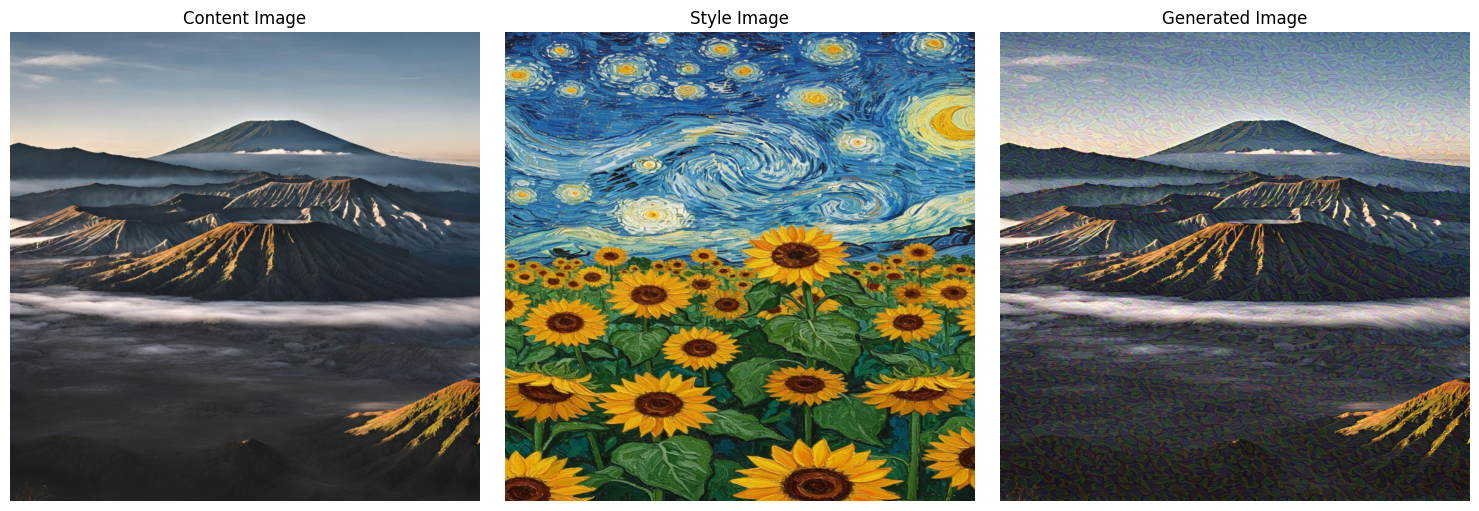

💾 Gambar hasil disimpan sebagai 'stylized_image_hq.jpg'
📐 Resolusi: 768x768 pixels
🎨 Kualitas: High Quality (95%)


In [1]:
# ============================================================================
# Nama : Haris Gunawan Romadon
# NIM : 41236718
# Kelas : TI2023-KIP-P2
# ============================================================================


import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg19
from tensorflow.keras.preprocessing import image as kp_image
import matplotlib.pyplot as plt
from PIL import Image
import time

# ============================================================================
# KONFIGURASI DAN PARAMETER
# ============================================================================

class StyleTransferConfig:
    """Konfigurasi untuk Neural Style Transfer"""

    # Layer yang digunakan untuk ekstraksi fitur
    CONTENT_LAYERS = ['block4_conv2', 'block5_conv2']  # Multi-layer untuk content lebih detail

    STYLE_LAYERS = [
        'block1_conv1',
        'block2_conv1',
        'block3_conv1',
        'block4_conv1',
        'block5_conv1'
    ]  # Layer untuk style

    # Bobot untuk loss function (disesuaikan untuk hasil optimal)
    CONTENT_WEIGHT = 1e4  # Ditingkatkan untuk mempertahankan struktur
    STYLE_WEIGHT = 1e-1  # Ditingkatkan untuk transfer style lebih kuat
    TOTAL_VARIATION_WEIGHT = 100  # Ditingkatkan untuk smoothness

    # Parameter optimasi (tuned untuk konvergensi lebih baik)
    LEARNING_RATE = 0.01  # Lebih lambat untuk hasil stabil
    BETA_1 = 0.99
    EPSILON = 1e-1

    # Ukuran gambar (diperbesar untuk detail lebih tinggi)
    IMG_HEIGHT = 768
    IMG_WIDTH = 768

config = StyleTransferConfig()

# ============================================================================
# FUNGSI PREPROCESSING DAN UTILITY
# ============================================================================

def load_and_process_image(image_path, img_height=768, img_width=768):
    """
    Load dan preprocess gambar untuk VGG19 dengan high-quality interpolation

    Args:
        image_path: Path ke file gambar
        img_height: Tinggi gambar output
        img_width: Lebar gambar output

    Returns:
        Tensor gambar yang sudah dipreprocess
    """
    # Load dengan PIL untuk kontrol lebih baik
    img = Image.open(image_path)

    # Resize dengan high-quality Lanczos resampling
    img = img.resize((img_width, img_height), Image.Resampling.LANCZOS)

    # Convert ke array
    img = kp_image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

def deprocess_image(processed_img):
    """
    Convert tensor kembali ke format gambar normal

    Args:
        processed_img: Tensor gambar yang sudah dipreprocess

    Returns:
        Array gambar dalam format RGB [0, 255]
    """
    x = processed_img.copy()
    if len(x.shape) == 4:
        x = np.squeeze(x, 0)

    # Reverse preprocessing VGG19
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]  # BGR to RGB

    x = np.clip(x, 0, 255).astype('uint8')
    return x

def display_images(content_path, style_path, generated_img):
    """
    Menampilkan gambar content, style, dan hasil

    Args:
        content_path: Path gambar konten
        style_path: Path gambar style
        generated_img: Gambar hasil generate
    """
    plt.figure(figsize=(15, 5))

    # Content image
    plt.subplot(1, 3, 1)
    content = Image.open(content_path)
    content = content.resize((config.IMG_WIDTH, config.IMG_HEIGHT))
    plt.imshow(content)
    plt.title('Content Image')
    plt.axis('off')

    # Style image
    plt.subplot(1, 3, 2)
    style = Image.open(style_path)
    style = style.resize((config.IMG_WIDTH, config.IMG_HEIGHT))
    plt.imshow(style)
    plt.title('Style Image')
    plt.axis('off')

    # Generated image
    plt.subplot(1, 3, 3)
    plt.imshow(generated_img)
    plt.title('Generated Image')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# ============================================================================
# MODEL BUILDING
# ============================================================================

def get_model():
    """
    Membuat model VGG19 untuk ekstraksi fitur

    Returns:
        Model keras yang mengembalikan aktivasi dari layer tertentu
    """
    # Load VGG19 tanpa fully connected layers
    vgg = vgg19.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    # Ambil output dari layer yang diperlukan
    style_outputs = [vgg.get_layer(name).output for name in config.STYLE_LAYERS]
    content_outputs = [vgg.get_layer(name).output for name in config.CONTENT_LAYERS]
    model_outputs = style_outputs + content_outputs

    # Buat model baru
    return keras.Model(vgg.input, model_outputs)

# ============================================================================
# LOSS FUNCTIONS
# ============================================================================

def gram_matrix(input_tensor):
    """
    Menghitung Gram Matrix untuk style representation
    Gram matrix mengukur korelasi antar feature maps

    Args:
        input_tensor: Feature maps dari CNN layer

    Returns:
        Gram matrix
    """
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)
    return result / num_locations

def compute_content_loss(content_features, generated_features):
    """
    Menghitung content loss
    Mengukur perbedaan antara konten gambar

    Args:
        content_features: Fitur dari gambar konten
        generated_features: Fitur dari gambar hasil

    Returns:
        Content loss value
    """
    return tf.reduce_mean(tf.square(content_features - generated_features))

def compute_style_loss(style_features, generated_features):
    """
    Menghitung style loss berdasarkan Gram matrices

    Args:
        style_features: Fitur dari gambar style
        generated_features: Fitur dari gambar hasil

    Returns:
        Style loss value
    """
    style_gram = gram_matrix(style_features)
    generated_gram = gram_matrix(generated_features)
    return tf.reduce_mean(tf.square(style_gram - generated_gram))

def compute_total_variation_loss(image):
    """
    Total Variation Loss untuk mengurangi noise
    Membuat gambar lebih smooth dan koheren

    Args:
        image: Gambar input

    Returns:
        TV loss value
    """
    x_deltas = image[:, :, 1:, :] - image[:, :, :-1, :]
    y_deltas = image[:, 1:, :, :] - image[:, :-1, :, :]
    return tf.reduce_mean(tf.abs(x_deltas)) + tf.reduce_mean(tf.abs(y_deltas))

# ============================================================================
# STYLE TRANSFER ENGINE
# ============================================================================

class NeuralStyleTransfer:
    """
    Class utama untuk Neural Style Transfer
    """

    def __init__(self, content_path, style_path):
        """
        Inisialisasi Neural Style Transfer

        Args:
            content_path: Path ke gambar konten
            style_path: Path ke gambar style
        """
        self.content_path = content_path
        self.style_path = style_path
        self.model = get_model()

        # Load dan preprocess images
        self.content_image = load_and_process_image(
            content_path, config.IMG_HEIGHT, config.IMG_WIDTH
        )
        self.style_image = load_and_process_image(
            style_path, config.IMG_HEIGHT, config.IMG_WIDTH
        )

        # Extract target features
        self.style_targets = self._extract_style_targets()
        self.content_targets = self._extract_content_targets()

        # Initialize generated image dengan blend content dan noise untuk konvergensi lebih baik
        noise = tf.random.uniform(self.content_image.shape, -20, 20)
        self.generated_image = tf.Variable(
            self.content_image + noise,
            dtype=tf.float32
        )

        # Setup optimizer dengan schedule learning rate
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=config.LEARNING_RATE,
            decay_steps=100,
            decay_rate=0.96,
            staircase=True
        )
        self.optimizer = tf.optimizers.Adam(
            learning_rate=lr_schedule,
            beta_1=config.BETA_1,
            epsilon=config.EPSILON
        )

    def _extract_style_targets(self):
        """Extract style features dari style image"""
        style_outputs = self.model(self.style_image)
        return style_outputs[:len(config.STYLE_LAYERS)]

    def _extract_content_targets(self):
        """Extract content features dari content image"""
        content_outputs = self.model(self.content_image)
        return content_outputs[len(config.STYLE_LAYERS):]

    @tf.function
    def _compute_loss(self):
        """
        Menghitung total loss

        Returns:
            loss: Total loss
            content_loss: Content loss
            style_loss: Style loss
            tv_loss: Total variation loss
        """
        # Forward pass
        outputs = self.model(self.generated_image)
        style_outputs = outputs[:len(config.STYLE_LAYERS)]
        content_outputs = outputs[len(config.STYLE_LAYERS):]

        # Content loss
        content_loss = tf.add_n([
            compute_content_loss(self.content_targets[i], content_outputs[i])
            for i in range(len(config.CONTENT_LAYERS))
        ])
        content_loss *= config.CONTENT_WEIGHT / len(config.CONTENT_LAYERS)

        # Style loss
        style_loss = tf.add_n([
            compute_style_loss(self.style_targets[i], style_outputs[i])
            for i in range(len(config.STYLE_LAYERS))
        ])
        style_loss *= config.STYLE_WEIGHT / len(config.STYLE_LAYERS)

        # Total variation loss
        tv_loss = compute_total_variation_loss(self.generated_image)
        tv_loss *= config.TOTAL_VARIATION_WEIGHT

        # Total loss
        loss = content_loss + style_loss + tv_loss

        return loss, content_loss, style_loss, tv_loss

    @tf.function
    def _train_step(self):
        """
        Satu step training menggunakan gradient descent

        Returns:
            loss: Total loss
            content_loss: Content loss
            style_loss: Style loss
            tv_loss: Total variation loss
        """
        with tf.GradientTape() as tape:
            loss, content_loss, style_loss, tv_loss = self._compute_loss()

        gradients = tape.gradient(loss, self.generated_image)
        self.optimizer.apply_gradients([(gradients, self.generated_image)])

        # Clip pixel values
        self.generated_image.assign(
            tf.clip_by_value(self.generated_image, -103.939, 255 - 103.939)
        )

        return loss, content_loss, style_loss, tv_loss

    def transfer_style(self, epochs=15, steps_per_epoch=150):
        """
        Melakukan style transfer dengan parameter optimal

        Args:
            epochs: Jumlah epoch (default: 15 untuk hasil maksimal)
            steps_per_epoch: Steps per epoch (default: 150)

        Returns:
            Generated image (numpy array)
        """
        print("🎨 Memulai Neural Style Transfer dengan Konfigurasi Optimal...")
        print(f"📊 Epochs: {epochs}, Steps per Epoch: {steps_per_epoch}")
        print(f"🖼️  Resolusi: {config.IMG_HEIGHT}x{config.IMG_WIDTH}")
        print(f"⚙️  Content Weight: {config.CONTENT_WEIGHT}, Style Weight: {config.STYLE_WEIGHT}")
        print("-" * 60)

        start_time = time.time()
        best_loss = float('inf')
        best_image = None

        for epoch in range(epochs):
            epoch_start = time.time()

            for step in range(steps_per_epoch):
                loss, content_loss, style_loss, tv_loss = self._train_step()

                # Simpan best image
                if loss < best_loss:
                    best_loss = loss
                    best_image = self.generated_image.numpy().copy()

                if step % 30 == 0:
                    print(f"Epoch {epoch+1}/{epochs}, Step {step}/{steps_per_epoch}")
                    print(f"  💫 Total Loss: {loss.numpy():.2f}")
                    print(f"  📄 Content Loss: {content_loss.numpy():.2f}")
                    print(f"  🎨 Style Loss: {style_loss.numpy():.2f}")
                    print(f"  ✨ TV Loss: {tv_loss.numpy():.2f}")

            epoch_time = time.time() - epoch_start
            print(f"⏱️  Epoch {epoch+1} selesai dalam {epoch_time:.2f} detik")

            # Display preview setiap 3 epoch
            # if (epoch + 1) % 3 == 0:
            #     preview = deprocess_image(self.generated_image.numpy())
            #     plt.figure(figsize=(8, 8))
            #     plt.imshow(preview)
            #     plt.title(f'Preview - Epoch {epoch+1}')
            #     plt.axis('off')
            #     plt.show()

            print("-" * 60)

        total_time = time.time() - start_time
        print(f"✅ Style Transfer selesai dalam {total_time:.2f} detik ({total_time/60:.2f} menit)")
        print(f"🏆 Best Loss: {best_loss:.2f}")

        # Gunakan best image untuk hasil akhir
        generated_img = deprocess_image(best_image if best_image is not None else self.generated_image.numpy())
        return generated_img

# ============================================================================
# FUNGSI UTAMA
# ============================================================================

def neural_style_transfer(content_path, style_path, epochs=15, steps_per_epoch=150,
                          content_weight=None, style_weight=None):
    """
    Fungsi utama untuk melakukan Neural Style Transfer dengan kualitas maksimal

    Args:
        content_path: Path ke gambar konten
        style_path: Path ke gambar style
        epochs: Jumlah epoch training (default: 15 untuk hasil optimal)
        steps_per_epoch: Steps per epoch (default: 150)
        content_weight: Custom content weight (optional)
        style_weight: Custom style weight (optional)

    Returns:
        Generated image
    """
    # Override weights jika diberikan
    if content_weight is not None:
        config.CONTENT_WEIGHT = content_weight
    if style_weight is not None:
        config.STYLE_WEIGHT = style_weight

    # Inisialisasi Neural Style Transfer
    nst = NeuralStyleTransfer(content_path, style_path)

    # Lakukan transfer
    generated_image = nst.transfer_style(epochs=epochs, steps_per_epoch=steps_per_epoch)

    # Display hasil
    display_images(content_path, style_path, generated_image)

    return generated_image

# ============================================================================
# CONTOH PENGGUNAAN
# ============================================================================

if __name__ == "__main__":
    # Path ke gambar (sesuaikan dengan lokasi file Anda)
    CONTENT_IMAGE_PATH = '/content/drive/MyDrive/STMIK IKMI Cirebon (1)/Semester 6/Deep Learning Lanjut/data/Gunung Bromo.jpeg'  # Gambar utama
    STYLE_IMAGE_PATH = '/content/drive/MyDrive/STMIK IKMI Cirebon (1)/Semester 6/Deep Learning Lanjut/data/sun-flowers.jpeg'      # Gambar style

    # KONFIGURASI OPTIMAL - Gunakan ini untuk hasil maksimal
    # result = neural_style_transfer(
    #     content_path=CONTENT_IMAGE_PATH,
    #     style_path=STYLE_IMAGE_PATH,
    #     epochs=15,            # Ditingkatkan untuk konvergensi lebih baik
    #     steps_per_epoch=150,  # Lebih banyak iterasi per epoch
    #     # content_weight=1e4,   # Uncomment untuk override
    #     # style_weight=1e-1     # Uncomment untuk override
    # )

    # ALTERNATIF: Untuk style lebih kuat (seperti Van Gogh)
    result = neural_style_transfer(
        content_path=CONTENT_IMAGE_PATH,
        style_path=STYLE_IMAGE_PATH,
        epochs=20,
        steps_per_epoch=150,
        content_weight=5e3,   # Lebih rendah
        style_weight=2e-1     # Lebih tinggi
    )

    # ALTERNATIF: Untuk mempertahankan detail konten lebih baik
    # result = neural_style_transfer(
    #     content_path=CONTENT_IMAGE_PATH,
    #     style_path=STYLE_IMAGE_PATH,
    #     epochs=15,
    #     steps_per_epoch=150,
    #     content_weight=2e4,   # Lebih tinggi
    #     style_weight=5e-2     # Lebih rendah
    # )

    # Save hasil dengan kualitas maksimal
    result_img = Image.fromarray(result)
    result_img.save('/content/stylized_image_hq.jpg', quality=95, optimize=True)
    print("💾 Gambar hasil disimpan sebagai 'stylized_image_hq.jpg'")
    print("📐 Resolusi: 768x768 pixels")
    print("🎨 Kualitas: High Quality (95%)")